In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

In [2]:
dataDir = 'C:\\Users\simin\OneDrive\Documents\Kaggle\Credit Default\data/'

# application data

In [4]:
# training data
app = pd.read_csv( dataDir + 'application_train.csv' )
print('Training data shape: ', app.shape)

# testing data (no lable)
app_submission = pd.read_csv( dataDir + 'application_test.csv' )
print('Submission data shape: ', app_submission.shape)

Training data shape:  (307511, 122)
Submission data shape:  (48744, 121)


### Explotory Data Analysis

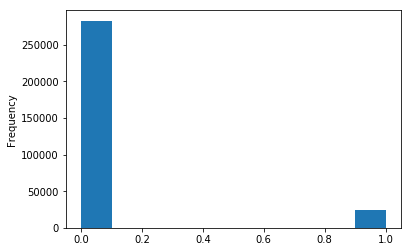

In [5]:
# Target data is unbalanced
app['TARGET'].astype(int).plot.hist()

### Missing value explotory

In [6]:
mis_val = app.isnull().sum()
mis_val_pct = mis_val *100 / len(app)

mis_val_table = pd.concat([mis_val, mis_val_pct], axis = 1)

mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values(
    by=['% of Total Values'], ascending=False)

mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns['% of Total Values']!=0] 
print("There are %d columns with missing value"% len(mis_val_table_ren_columns))

There are 67 columns with missing value


### Label Encoding and One-Hot Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

for col in app:
    if app[col].dtype == 'object':
        if len(list(app[col].unique())) <= 2:
            le.fit(app[col])
            
            app[col] = le.transform(app[col])
            app_submission[col] = le.transform(app_submission[col])
            
            le_count += 1
            
print("%d columns were label encoded."%le_count)

3 columns were label encoded.


In [8]:
# one-hot encoding of categorical variables
app = pd.get_dummies(app)
app_submission = pd.get_dummies(app_submission)

print('Training Features shape: ', app.shape)
print('Submission Features shape: ', app_submission.shape)

Training Features shape:  (307511, 243)
Submission Features shape:  (48744, 239)


### Aligning Training and Testing Data (Training and Testing shapes are different)

In [9]:
y = app['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app, app_submission = app.align(app_submission, join = 'inner', axis = 1)

print('Training Features shape: ', app.shape)
print('Submission Features shape: ', app_submission.shape)

Training Features shape:  (307511, 239)
Submission Features shape:  (48744, 239)


Text(0.5,0,'Days Employment')

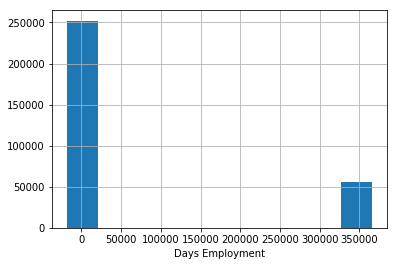

In [10]:
app['DAYS_EMPLOYED'].hist()
plt.xlabel('Days Employment')

Text(0.5,0,'Days Employment')

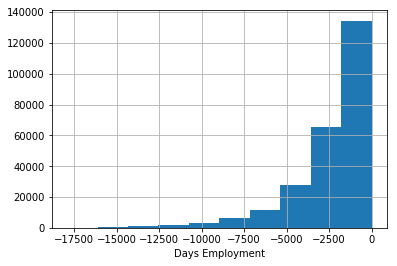

In [11]:
# This looks like unreasonable

# Replace the anomalous values with nan
app['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app['DAYS_EMPLOYED'].hist()
plt.xlabel('Days Employment')

In [12]:
# Do the samething to the testing data
app_submission["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

### Polynomial features

In [15]:
# Make a new dataframe for polynomial features
poly_features = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_features_submission = app_submission[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.preprocessing import Imputer
ip = Imputer(strategy='median')

poly_target = y

poly_features = ip.fit_transform(poly_features)
poly_features_submission = ip.fit_transform(poly_features_submission)

from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree = 3)

poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_submission = poly_transformer.transform(poly_features_submission)

# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(
                                 ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['TARGET'] = poly_target

poly_features_submission = pd.DataFrame(poly_features_submission, 
                             columns = poly_transformer.get_feature_names(
                                 ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['SK_ID_CURR'] = app['SK_ID_CURR']
poly_features_submission['SK_ID_CURR'] = app_submission['SK_ID_CURR']

app_poly = app.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
app_submission_poly = app_submission.merge(poly_features_submission, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_poly, app_submission_poly = app_poly.align(app_submission_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_poly.shape)
print('Submission data with polynomial features shape:  ', app_submission_poly.shape)

Training data with polynomial features shape:  (307511, 274)
Submission data with polynomial features shape:   (48744, 274)


### Domain Knowledge

In [16]:
app_domain = app.copy()
app_submission_domain = app_submission.copy()

app_domain['CREDIT_INCOME_PERCENT'] = app_domain['AMT_CREDIT'] / app_domain['AMT_INCOME_TOTAL']
app_domain['ANNUITY_INCOME_PERCENT'] = app_domain['AMT_ANNUITY'] / app_domain['AMT_INCOME_TOTAL']
app_domain['CREDIT_TERM'] = app_domain['AMT_ANNUITY'] / app_domain['AMT_CREDIT']
app_domain['DAYS_EMPLOYED_PERCENT'] = app_domain['DAYS_EMPLOYED'] / app_domain['DAYS_BIRTH']

app_submission_domain['CREDIT_INCOME_PERCENT'] = app_submission_domain['AMT_CREDIT'] / app_submission_domain['AMT_INCOME_TOTAL']
app_submission_domain['ANNUITY_INCOME_PERCENT'] = app_submission_domain['AMT_ANNUITY'] / app_submission_domain['AMT_INCOME_TOTAL']
app_submission_domain['CREDIT_TERM'] = app_submission_domain['AMT_ANNUITY'] / app_submission_domain['AMT_CREDIT']
app_submission_domain['DAYS_EMPLOYED_PERCENT'] = app_submission_domain['DAYS_EMPLOYED'] / app_submission_domain['DAYS_BIRTH']

### Data Preprocessing

In [17]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app:
    X = app.drop(columns = ['TARGET'])
else:
    X = app.copy()
    
# Label data
Y = y.values

# Copy of the testing data
X_submission = app_submission.copy()

X = X.drop('SK_ID_CURR', axis = 1)
X_submission = X_submission.drop('SK_ID_CURR', axis = 1)
    
# Feature names
features = list(X.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
imputer.fit(X)
X = imputer.transform(X)
X_submission = imputer.transform(X_submission)

# Repeat with the scaler
scaler.fit(X)
X = scaler.transform(X)
X_submission = scaler.transform(X_submission)

print('Training data shape: ', X.shape)
print('Training label shape: ', Y.shape)
print('Submission data shape: ', X_submission.shape)

Training data shape:  (307511, 238)
Training label shape:  (307511,)
Submission data shape:  (48744, 238)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [20]:
import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
predictions = gbm.predict_proba(X_test)

C:\Users\simin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


No handles with labels found to put in legend.


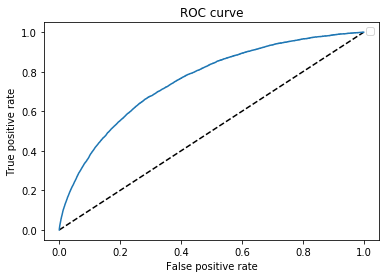

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1], pos_label=1)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [23]:
print(roc_auc_score(y_test, predictions[:,1]))

0.7553929303579122


In [10]:
# one hot encoding for categorical variables
one_hot_encoded_X_train = pd.get_dummies(X_train)
one_hot_encoded_X_test = pd.get_dummies(X_test)
encoded_X_train, encoded_X_test = one_hot_encoded_X_train.align(one_hot_encoded_X_test,
                                                                    join='left', 
                                                                    axis=1)

In [12]:
# check the columns after one hot encoding
print(encoded_X_train.columns)

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=245)


In [14]:
print(X_train.shape)
print(encoded_X_train.shape)

(276759, 121)
(276759, 245)


In [15]:
# handle missiong values
columns = X_train.columns
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column / float(X_train.shape[0]))
# check if there is any missing y
print(y_train.isnull().sum(), y_test.isnull().sum())

SK_ID_CURR                      0.000000
NAME_CONTRACT_TYPE              0.000000
CODE_GENDER                     0.000000
FLAG_OWN_CAR                    0.000000
FLAG_OWN_REALTY                 0.000000
CNT_CHILDREN                    0.000000
AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
AMT_ANNUITY                     0.000036
AMT_GOODS_PRICE                 0.000896
NAME_TYPE_SUITE                 0.004220
NAME_INCOME_TYPE                0.000000
NAME_EDUCATION_TYPE             0.000000
NAME_FAMILY_STATUS              0.000000
NAME_HOUSING_TYPE               0.000000
REGION_POPULATION_RELATIVE      0.000000
DAYS_BIRTH                      0.000000
DAYS_EMPLOYED                   0.000000
DAYS_REGISTRATION               0.000000
DAYS_ID_PUBLISH                 0.000000
OWN_CAR_AGE                     0.659736
FLAG_MOBIL                      0.000000
FLAG_EMP_PHONE                  0.000000
FLAG_WORK_PHONE                 0.000000
FLAG_CONT_MOBILE

In [17]:
# may need to handle each column with different strategy, but now I just impute using most frequent one
from sklearn.preprocessing import Imputer
my_imputer = Imputer(strategy = 'most_frequent')
encoded_X_train_imputed = my_imputer.fit_transform(encoded_X_train)
encoded_X_test_imputed = my_imputer.transform(encoded_X_test)


In [18]:
import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(encoded_X_train_imputed, y_train)
predictions = gbm.predict(encoded_X_test_imputed)

C:\Users\simin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\simin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [34]:
pred_prob = gbm.predict_proba(encoded_X_test_imputed)

In [38]:
pred_prob

array([[0.79522026, 0.20477973],
       [0.9564121 , 0.04358793],
       [0.84712785, 0.15287213],
       ...,
       [0.9844243 , 0.01557573],
       [0.9559125 , 0.04408751],
       [0.8820837 , 0.11791629]], dtype=float32)

In [39]:
pred_prob[:,1]

array([0.20477973, 0.04358793, 0.15287213, ..., 0.01557573, 0.04408751,
       0.11791629], dtype=float32)

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1], pos_label=1)


No handles with labels found to put in legend.


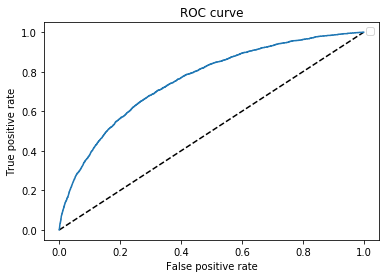

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [45]:
print(roc_auc_score(y_test, pred_prob[:,1]))

0.7575828372663722


# bureau_balance

In [ ]:
application_train = pd.read_csv( dataDir + 'application_train.csv' )